In [2]:
import pandas as pd
import numpy as np
from scipy.stats import zscore
from joblib import Parallel, delayed
from timeit import default_timer as timer

In [3]:
cp_file = '../../data/causal-priors.txt'
sde_file = '../../data/mouse_to_human_normalized5k.tsv'

cpo_df = pd.read_csv(cp_file, sep='\t', header=None, usecols=[0, 1, 2], names=['symbol', 'action', 'targetSymbol'])
cpo_df = cpo_df[cpo_df['action'].isin(['upregulates-expression', 'downregulates-expression'])]
cpo_df.reset_index(drop=True, inplace=True)
cpo_df['isUp'] = np.where(cpo_df['action'] == 'upregulates-expression', 1, -1)
cpo_df.drop(['action'], axis=1, inplace=True)

sde_df = pd.read_csv(sde_file, sep='\t', header=0, index_col=0).T
sde_df.replace(0, np.nan, inplace=True)
sde_df = pd.DataFrame(zscore(sde_df, nan_policy='omit'), index=sde_df.index, columns=sde_df.columns)
print("Files read complete...")

Files read complete...


In [4]:
# There may be some targetSymbols in cpo_df which are not present in sde_df
# Now remove those rows from cpo_df
cpo_df = cpo_df[cpo_df['targetSymbol'].isin(sde_df.columns)]
cpo_df.reset_index(drop=True, inplace=True)
cpo_df.head()

,symbol,targetSymbol,isUp
0,XBP1,TPP1,1
1,KLF5,CXCR4,1
2,ATF3,SELE,-1
3,MYC,EIF4G1,1
4,LDHA,HIF1A,1


In [5]:
cpo_grouped_df = cpo_df.groupby('symbol')['isUp'].apply(list).reset_index(name='upDownList')
cpo_grouped_df['targetList'] = cpo_df.groupby('symbol')['targetSymbol'].apply(list).reset_index(name='targetList')[
    'targetList']
cpo_grouped_df['upDownCount'] = cpo_grouped_df['upDownList'].apply(lambda x: len(x))
max_target = np.max(cpo_grouped_df['upDownCount'])
cpo_grouped_df.head()

,symbol,upDownList,targetList,upDownCount
0,A2M,[1],[STAT3],1
1,AATF,"[-1, -1]","[BAX, CTNNB1]",2
2,ABCA1,"[1, 1, -1, -1]","[NR1H2, NR1H3, GLI2, SREBF2]",4
3,ABCA3,"[1, 1, 1, 1, 1]","[SREBF1, GATA6, FOXA2, NFATC3, CEBPA]",5
4,ABCB1,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[SP1, RELB, RELA, TCF7L2, FOXO1, EGR1, CEBPB, ...",10


### 1. Generating distribution using cumulative sum

In [27]:
# n = 10_000
# ranks = [(i + 0.5) / n for i in range(1, n)]
#
# # Generate Distribution
# iters = 10_000
#
# distribution = np.zeros((max_target, iters))
#
# # Took 13 seconds for 10,000 iterations
# for i in range(iters):
#     cs = np.random.choice(ranks, max_target, replace=False).cumsum()
#     for target in range(1, max_target + 1):
#         amr = cs[target - 1] / target
#         distribution[target - 1, i] = np.min([amr, 1 - amr])
#
# distribution = np.sort(distribution, axis=1)
# distribution
#
#
# # Took multiple minutes for 10,000 iterations
# # for target in range(1, max_target + 1):
# #     arr = np.zeros(iters)
# #     for i in range(iters):
# #         amr = np.mean(np.random.choice(ranks, target, replace=False))
# #         imr = 1 - amr
# #         arr[i] = np.min([amr, imr])
# #     distribution[target - 1] = np.sort(arr)
# #
# # distribution

In [28]:
# # Another way to generate distribution
# n = 10_000
# iters = 1000
# distribution = np.zeros((max_target, iters))
#
# for target in range(1, max_target + 1):
#     arr = np.zeros(iters)
#     for i in range(iters):
#         amr = (np.mean(np.random.choice(n, target, replace=False)) + 0.5) / n
#         imr = 1 - amr
#         arr[i] = np.min([amr, imr])
#     distribution[target - 1] = arr
#
# distribution

In [29]:
# # Another way to generate distribution
# n = 10_000
# distribution = []
# iters = 1000
# max_target = 218
#
# # Took 21 seconds to run
# for target in range(1, max_target + 1):
#     arr = []
#     for i in range(iters):
#         amr = (np.mean(np.random.choice(n, target, replace=False)) + 0.5) / n
#         imr = 1 - amr
#         arr.append(np.min([amr, imr]))
#     distribution.append(arr)
#
# distribution = np.array(distribution)
# distribution

### 2. Generating Distribution Using parallel processing

In [30]:
# n = 10_000
# ranks = [(i + 0.5) / n for i in range(1, n)]
# iters = 10_000
#
#
# # Worker function that each process will run
# # Took 1 min 46 seconds for 10,000 iterations
# def worker(target):
#     arr = np.zeros(iters)
#     for i in range(iters):
#         amr = np.mean(np.random.choice(ranks, target, replace=False))
#         imr = 1 - amr
#         arr[i] = np.min([amr, imr])
#     return np.sort(arr)
#
#
# distribution = Parallel(n_jobs=-1)(delayed(worker)(target) for target in range(1, max_target + 1))
#
# distribution = np.array(distribution)
# distribution

### 3. Can we combine both methods? Let's try

In [33]:
n = 10_000
ranks = [(i + 0.5) / n for i in range(1, n)]
iters = 1_0000_000


def worker(iter):
    arr = np.zeros(max_target)
    cs = np.random.choice(ranks, max_target, replace=False).cumsum()
    for target in range(1, max_target + 1):
        amr = cs[target - 1] / target
        arr[target - 1] = np.min([amr, 1 - amr])
    return arr


distribution = Parallel(n_jobs=-1)(delayed(worker)(iter) for iter in range(iters))
# 1M x 218

# Transpose distribution
distribution = np.array(distribution).T
distribution = np.sort(distribution, axis=1)
distribution

array([[5.00000000e-05, 5.00000000e-05, 5.00000000e-05, ...,
        4.99950000e-01, 4.99950000e-01, 4.99950000e-01],
       [4.00000000e-04, 4.50000000e-04, 5.00000000e-04, ...,
        5.00000000e-01, 5.00000000e-01, 5.00000000e-01],
       [2.15000000e-03, 2.41666667e-03, 2.95000000e-03, ...,
        4.99983333e-01, 4.99983333e-01, 4.99983333e-01],
       ...,
       [3.81577315e-01, 3.98413426e-01, 4.01097685e-01, ...,
        5.00000000e-01, 5.00000000e-01, 5.00000000e-01],
       [3.80010369e-01, 3.96728802e-01, 4.02132949e-01, ...,
        4.99999770e-01, 4.99999770e-01, 4.99999770e-01],
       [3.82460550e-01, 3.95795872e-01, 4.01472018e-01, ...,
        5.00000000e-01, 5.00000000e-01, 5.00000000e-01]])

In [34]:
# Save distribution
# np.save('data/distribution.npy', distribution)

# save to compressed npy file
np.savez_compressed('data/distribution10m.npz', distribution=distribution)

In [29]:
# load npz file to numpy array
distribution = np.load('data/distribution10m.npz')['distribution']
distribution

array([[5.00000000e-05, 5.00000000e-05, 5.00000000e-05, ...,
        4.99950000e-01, 4.99950000e-01, 4.99950000e-01],
       [4.00000000e-04, 4.50000000e-04, 5.00000000e-04, ...,
        5.00000000e-01, 5.00000000e-01, 5.00000000e-01],
       [2.15000000e-03, 2.41666667e-03, 2.95000000e-03, ...,
        4.99983333e-01, 4.99983333e-01, 4.99983333e-01],
       ...,
       [3.81577315e-01, 3.98413426e-01, 4.01097685e-01, ...,
        5.00000000e-01, 5.00000000e-01, 5.00000000e-01],
       [3.80010369e-01, 3.96728802e-01, 4.02132949e-01, ...,
        4.99999770e-01, 4.99999770e-01, 4.99999770e-01],
       [3.82460550e-01, 3.95795872e-01, 4.01472018e-01, ...,
        5.00000000e-01, 5.00000000e-01, 5.00000000e-01]])

### For each cell in single cell data

In [30]:
cpo_df_c_grouped = None
iters = 10_000_000
# Now Calculate actual RM for each cell

# result = pd.DataFrame(columns=cpo_grouped_df['symbol'].values, index=sde_df.index)
result = pd.DataFrame(columns=cpo_grouped_df['symbol'].values, index=sde_df.index[:50])
cell_count = 0

for idx, row in sde_df.head(50).iterrows():
    time = timer()
    cell = pd.DataFrame(row.index, columns=['symbol'])
    cell['zscore'] = row.values
    # Remove rows of cell if zscore is nan
    cell.dropna(inplace=True)
    cell.reset_index(drop=True, inplace=True)
    cell.sort_values(by=['zscore'], ascending=[False], inplace=True)
    cell.reset_index(drop=True, inplace=True)

    cell['acti_rank'] = cell.index
    cell['acti_rank'] = (cell['acti_rank'] + 0.5) / len(cell)

    cell['inhi_rank'] = 1 - cell['acti_rank']

    cpo_df_c = cpo_df.copy()
    cpo_df_c = cpo_df_c[cpo_df_c['targetSymbol'].isin(cell['symbol'])]
    cpo_df_c.reset_index(drop=True, inplace=True)

    cpo_df_c['pos_rs'] = cpo_df_c.apply(
        lambda x:
        cell.loc[cell['symbol'] == x['targetSymbol'], 'acti_rank'].values[0]
        if x['isUp'] == 1
        else
        cell.loc[cell['symbol'] == x['targetSymbol'], 'inhi_rank'].values[0],
        axis=1
    )
    cpo_df_c['neg_rs'] = 1 - cpo_df_c['pos_rs']

    # Group
    cpo_df_c_grouped = cpo_df_c.groupby('symbol')['isUp'].apply(list).reset_index(name='upDownList')
    cpo_df_c_grouped['targetList'] = cpo_df_c.groupby('symbol')['targetSymbol'].apply(list).reset_index(
        name='targetList')['targetList']
    cpo_df_c_grouped['upDownCount'] = cpo_df_c_grouped['upDownList'].apply(lambda x: len(x))
    cpo_df_c_grouped['pos_rs'] = cpo_df_c.groupby('symbol')['pos_rs'].apply(list).reset_index(name='pos_rs')[
        'pos_rs']
    cpo_df_c_grouped['neg_rs'] = cpo_df_c.groupby('symbol')['neg_rs'].apply(list).reset_index(name='neg_rs')[
        'neg_rs']
    cpo_df_c_grouped['rs'] = cpo_df_c_grouped.apply(
        lambda x: np.min([np.mean(x['pos_rs']), np.mean(x['neg_rs'])]),
        axis=1
    )
    # if rs is pos_rs then it is up, if rs is neg_rs then it is down. So if rs is neg_rs then we need to multiply it by -1
    cpo_df_c_grouped['rs'] = cpo_df_c_grouped.apply(
        lambda x: x['rs'] if np.mean(x['pos_rs']) > np.mean(x['neg_rs']) else -1 * x['rs'],
        axis=1
    )

    # Counting how many times the RS is less than the random distribution
    for idx1, row1 in cpo_df_c_grouped.iterrows():
        target = row1['upDownCount']
        rs = row1['rs']
        arr = distribution[target - 1]
        count = np.searchsorted(arr, rs)
        if count == 0:
            count = count + 1
        if np.sign(rs) == -1:
            count = -1 * count
        cpo_df_c_grouped.loc[idx1, 'count'] = count
        cpo_df_c_grouped.loc[idx1, 'p-value'] = count / iters

    # Collect p-values of all cells
    result.loc[idx, cpo_df_c_grouped['symbol']] = cpo_df_c_grouped['p-value'].values
    cell_count += 1
    print(f"Cell number: {cell_count} Time taken:  {timer() - time} seconds")

# Remove columns if all values are nan
result.dropna(axis=1, how='all', inplace=True)
result.to_csv('data/result.tsv', sep='\t')

Cell number: 1 Time taken:  0.2665394659998128 seconds
Cell number: 2 Time taken:  0.4558009820029838 seconds
Cell number: 3 Time taken:  0.6704007819935214 seconds
Cell number: 4 Time taken:  0.5990080229967134 seconds
Cell number: 5 Time taken:  0.41570452200539876 seconds
Cell number: 6 Time taken:  0.35773616000369657 seconds
Cell number: 7 Time taken:  0.40069341100752354 seconds
Cell number: 8 Time taken:  0.29970367001078557 seconds
Cell number: 9 Time taken:  0.47062886599451303 seconds
Cell number: 10 Time taken:  0.7087949150009081 seconds
Cell number: 11 Time taken:  0.3247533549874788 seconds
Cell number: 12 Time taken:  0.5457412560062949 seconds
Cell number: 13 Time taken:  0.472177855001064 seconds
Cell number: 14 Time taken:  0.2011762030015234 seconds
Cell number: 15 Time taken:  0.3339941669983091 seconds
Cell number: 16 Time taken:  0.4219153719895985 seconds
Cell number: 17 Time taken:  0.7402857730048709 seconds
Cell number: 18 Time taken:  0.4548004079988459 secon

KeyboardInterrupt: 

In [19]:
result.shape

(50, 1476)

### Lets parallelize the above code

In [31]:
iters = 10_000_000

result = pd.DataFrame(columns=cpo_grouped_df['symbol'].values, index=sde_df.index)


def cell_worker(row, idx):
    # time = timer()
    cell = pd.DataFrame({'symbol': row.index, 'zscore': row.values})
    # Remove rows of cell if zscore is nan
    cell.dropna(inplace=True)
    cell.reset_index(drop=True, inplace=True)
    cell.sort_values(by=['zscore'], ascending=[False], inplace=True)
    cell.reset_index(drop=True, inplace=True)

    cell['acti_rank'] = cell.index
    cell['acti_rank'] = (cell['acti_rank'] + 0.5) / len(cell)
    cell['inhi_rank'] = 1 - cell['acti_rank']

    cpo_df_c = cpo_df.copy()
    cpo_df_c = cpo_df_c[cpo_df_c['targetSymbol'].isin(cell['symbol'])]
    cpo_df_c.reset_index(drop=True, inplace=True)

    cpo_df_c['pos_rs'] = cpo_df_c.apply(
        lambda x:
        cell.loc[cell['symbol'] == x['targetSymbol'], 'acti_rank'].values[0]
        if x['isUp'] == 1
        else
        cell.loc[cell['symbol'] == x['targetSymbol'], 'inhi_rank'].values[0],
        axis=1
    )
    cpo_df_c['neg_rs'] = 1 - cpo_df_c['pos_rs']

    # Group
    cpo_df_c_grouped = cpo_df_c.groupby('symbol')['isUp'].apply(list).reset_index(name='upDownList')
    cpo_df_c_grouped['targetList'] = \
        cpo_df_c.groupby('symbol')['targetSymbol'].apply(list).reset_index(name='targetList')['targetList']
    cpo_df_c_grouped['upDownCount'] = cpo_df_c_grouped['upDownList'].apply(lambda x: len(x))
    cpo_df_c_grouped['pos_rs'] = cpo_df_c.groupby('symbol')['pos_rs'].apply(list).reset_index(name='pos_rs')['pos_rs']
    cpo_df_c_grouped['neg_rs'] = cpo_df_c.groupby('symbol')['neg_rs'].apply(list).reset_index(name='neg_rs')['neg_rs']
    cpo_df_c_grouped['rs'] = cpo_df_c_grouped.apply(
        lambda x: np.min([np.mean(x['pos_rs']), np.mean(x['neg_rs'])]), axis=1
    )
    # if rs is pos_rs then it is up, if rs is neg_rs then it is down. So if rs is neg_rs then we need to multiply it by -1
    cpo_df_c_grouped['rs'] = cpo_df_c_grouped.apply(
        lambda x: x['rs'] if np.mean(x['pos_rs']) > np.mean(x['neg_rs']) else -1 * x['rs'], axis=1
    )

    # Counting how many times the RS is less than the random distribution
    for idx1, row1 in cpo_df_c_grouped.iterrows():
        arr = distribution[row1['upDownCount'] - 1]
        rs_count = np.searchsorted(arr, row1['rs'])
        if rs_count == 0:
            rs_count = rs_count + 1
        if np.sign(row1['rs']) == -1:
            rs_count = -1 * rs_count
        cpo_df_c_grouped.loc[idx1, 'count'] = rs_count
        cpo_df_c_grouped.loc[idx1, 'p-value'] = rs_count / iters

    result.loc[idx, cpo_df_c_grouped['symbol']] = cpo_df_c_grouped['p-value'].values
    return result.loc[idx].values


parallel = Parallel(n_jobs=-1, verbose=10, backend="multiprocessing")
output = parallel(delayed(cell_worker)(row, idx) for idx, row in sde_df.iterrows())
output = pd.DataFrame(output, columns=cpo_grouped_df['symbol'].values, index=sde_df.index)
output.dropna(axis=1, how='all', inplace=True)
output.to_csv('data/output_parallel.tsv', sep='\t')

output

[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 28 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 106 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 125 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 186 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 209 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 232 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 257 tasks      |

,A2M,AATF,ABCA1,ABCA3,ABCB1,ABCG1,ABCG5,ABCG8,ABL1,ACACA,...,ZNF350,ZNF382,ZNF383,ZNF385A,ZNF444,ZNF467,ZNF638,ZNF76,ZNRD1,ZYX
midpoint_AAACCTGCACCCAGTG-1,NaN,NaN,NaN,-1.000000e-07,-1.000000e-07,NaN,NaN,NaN,5.659419e-01,NaN,...,NaN,1.963683e-01,NaN,4.533515e-01,NaN,NaN,NaN,NaN,NaN,NaN
midpoint_AAACCTGCAGCTTAAC-1,0.677111,NaN,NaN,NaN,-1.000000e-07,NaN,NaN,NaN,-1.000000e-07,NaN,...,NaN,5.918660e-01,NaN,-1.000000e-07,NaN,NaN,NaN,5.707351e-01,NaN,NaN
midpoint_AAACCTGGTGTGCGTC-1,0.893910,2.113175e-01,NaN,-1.000000e-07,3.052760e-02,NaN,NaN,NaN,-1.000000e-07,NaN,...,2.450706e-01,-1.000000e-07,-1.000000e-07,-1.000000e-07,NaN,NaN,NaN,5.635126e-01,NaN,-1.000000e-07
midpoint_AAACCTGGTTGAACTC-1,0.974321,NaN,-1.000000e-07,-1.000000e-07,-1.000000e-07,-1.000000e-07,-1.000000e-07,-1.000000e-07,9.781122e-01,-1.000000e-07,...,NaN,6.536430e-02,1.842525e-01,2.382358e-01,NaN,NaN,NaN,-1.000000e-07,0.765877,NaN
midpoint_AAACGGGAGGATGGTC-1,0.466762,-1.000000e-07,-1.000000e-07,NaN,5.493695e-01,-1.000000e-07,-1.000000e-07,-1.000000e-07,2.410608e-01,NaN,...,-1.000000e-07,-1.000000e-07,-1.000000e-07,2.973550e-02,NaN,NaN,NaN,-1.000000e-07,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tumor_TTTCCTCGTATGCTTG-1,0.035907,-1.000000e-07,3.919120e-01,NaN,-1.000000e-07,2.479063e-01,2.479063e-01,2.479063e-01,4.314475e-01,NaN,...,1.192393e-01,7.069640e-02,3.347581e-01,-1.000000e-07,NaN,NaN,NaN,3.394855e-01,NaN,4.529453e-01
tumor_TTTGCGCCACGGTTTA-1,0.033517,-1.000000e-07,4.430793e-01,8.286626e-01,-1.000000e-07,2.595700e-01,2.595700e-01,2.595700e-01,-1.000000e-07,8.286626e-01,...,8.395017e-01,-1.000000e-07,3.628036e-01,-1.000000e-07,NaN,NaN,NaN,2.595700e-01,NaN,-1.000000e-07
tumor_TTTGGTTCAGCCTGTG-1,0.073846,1.728569e-01,1.828797e-01,6.590581e-01,1.079600e-03,2.035657e-01,2.035657e-01,2.035657e-01,1.582754e-01,NaN,...,-1.000000e-07,-1.000000e-07,7.714933e-01,-1.000000e-07,NaN,NaN,NaN,-1.000000e-07,NaN,NaN
tumor_TTTGGTTCAGTGAGTG-1,0.032517,9.817630e-01,-1.000000e-07,2.829734e-01,8.013800e-03,6.511015e-01,6.511015e-01,6.511015e-01,-1.000000e-07,NaN,...,1.914890e-02,-1.000000e-07,-1.000000e-07,-1.000000e-07,NaN,NaN,NaN,2.394942e-01,0.087613,4.367911e-01


In [32]:
output.shape

(4797, 1709)

---

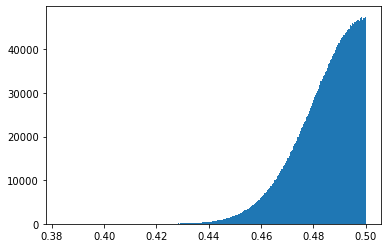

In [35]:
import matplotlib.pyplot as plt

t1 = distribution[210]

# bins and count from plt.hist
count, bins, ignored = plt.hist(t1, bins=1000)
plt.show()